In [37]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import catboost as ctb
import xgboost as xgb
from xgboost import XGBRegressor

import re
import sys

np.random.seed(0)

from sklearn.metrics import mean_absolute_error

from scikitplot.estimators import plot_learning_curve

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

from tqdm import tqdm

import scikitplot as skplt 

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [38]:
train = pd.read_hdf('./input/property.train.h5')
test = pd.read_hdf('./input/property.test.h5')

# Connecting train & test

In [176]:
df_all = pd.concat([train, test], axis=0)
#print("train & test: ", train.shape, test.shape)

# Missing values

In [40]:
def check_missing(df):
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)

In [41]:
df = df_all.fillna(-1)

# Feature engineering

In [42]:
#Extract breadcrumbs
for i in range(0,8):
   df["breadcrumbs_{}:".format(i)] = df["breadcrumbs"].apply(pd.Series)[i]

In [43]:
#Extract date
def extract_date(vals):
    return {"date_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

df_date = df["date"].map(extract_date).apply(pd.Series)

In [44]:
df_date[['d', 'm', 'r']] = df_date['date_0'].str.split(' ', expand=True)
df_date[['up', 'd_up', 'm_up', 'r_up']] = df_date['date_3'].str.split(' ', expand=True)

In [45]:
months = {'января':1, 'февраля':2, 'марта':3, 'апреля':4, 'мая':5, 'июня':6, 'июля': 7, 
'августа': 8, 'сентября':9, 'октября':10, 'ноября':11, 'декабря':12, 'в': 0} 

In [46]:
def months_num(month):
    for k,v in months.items():
        if month == k:
            return str(v)

df_date['m_cat'] = df_date['m'].apply(lambda x: months_num(x))

In [47]:
df_date['r_fill'] = df_date['r'].fillna(2019)

In [48]:
df_date['r_fill'][df_date['d']=='сегодня']=2019
df_date['r_fill'][df_date['d']=='вчера']=2019

In [49]:
df_full_date = pd.DataFrame({'year': df_date['r_fill'],
                   'month': df_date['m_cat'],
                   'day': df_date['d']})

In [50]:
pd.to_datetime(df_full_date, errors='coerce').max()

Timestamp('2019-05-18 00:00:00')

In [51]:
def days(day):
    if day == 'сегодня':
        return 19
    elif day == 'вчера':
        return 18
    else:
        return int(day)

df_date['d_new'] = df_date['d'].apply(lambda x: int(days(x)))

In [52]:
months_fill = {'января':1, 'февраля':2, 'марта':3, 'апреля':4, 'мая':5, 'июня':6, 'июля': 7, 
'августа': 8, 'сентября':9, 'октября':10, 'ноября':11, 'декабря':12, 'в': 5} 

In [53]:
def months_5(month):
    for k,v in months_fill.items():
        if month == k:
            return str(v)

df_date['m_cat_5'] = df_date['m'].apply(lambda x: months_5(x))

In [54]:
full_date_f = pd.DataFrame({'year': df_date['r_fill'],
                   'month': df_date['m_cat_5'],
                   'day': df_date['d_new']})

In [55]:
df_date['full_date_f'] = pd.to_datetime(full_date_f, errors='coerce')

In [56]:
df = pd.concat([df, df_date['full_date_f'], df_date['up'], df_date['date_1']], axis=1)

In [76]:
df["date_week_cat"] = df['full_date_f'].dt.week
df["date_month_cat"] = df['full_date_f'].dt.month
df["date_year_cat"] = df['full_date_f'].dt.year
df["date_dif_cat"] = (df['full_date_f'].max() - df['full_date_f']).astype('timedelta64[D]')

<ipython-input-76-c4f6f353ebf8>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["date_week_cat"] = df['full_date_f'].dt.week


# Factorize_feats

In [78]:
df['up_cat'] = df['up'].factorize()[0]

In [79]:
factorize_feats = [f for f in df.columns if ":" in f]
for feat in factorize_feats:
    df["{}_cat".format(feat.lower().replace(' ', '_').replace(':',''))] = df[feat].factorize()[0]

In [175]:
feats = [x for x in df.columns if "_cat" in x]
#print("feats: ", feats)

# Separate df

In [81]:
df_train, df_test = df[ False ==  (df["price"] == -1) ], df[ df["price"] == -1 ]

# Target value

<ipython-input-82-9a96e3458a6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['price_log'] = np.log( df_train['price'] )


<Figure size 36000x1440 with 0 Axes>

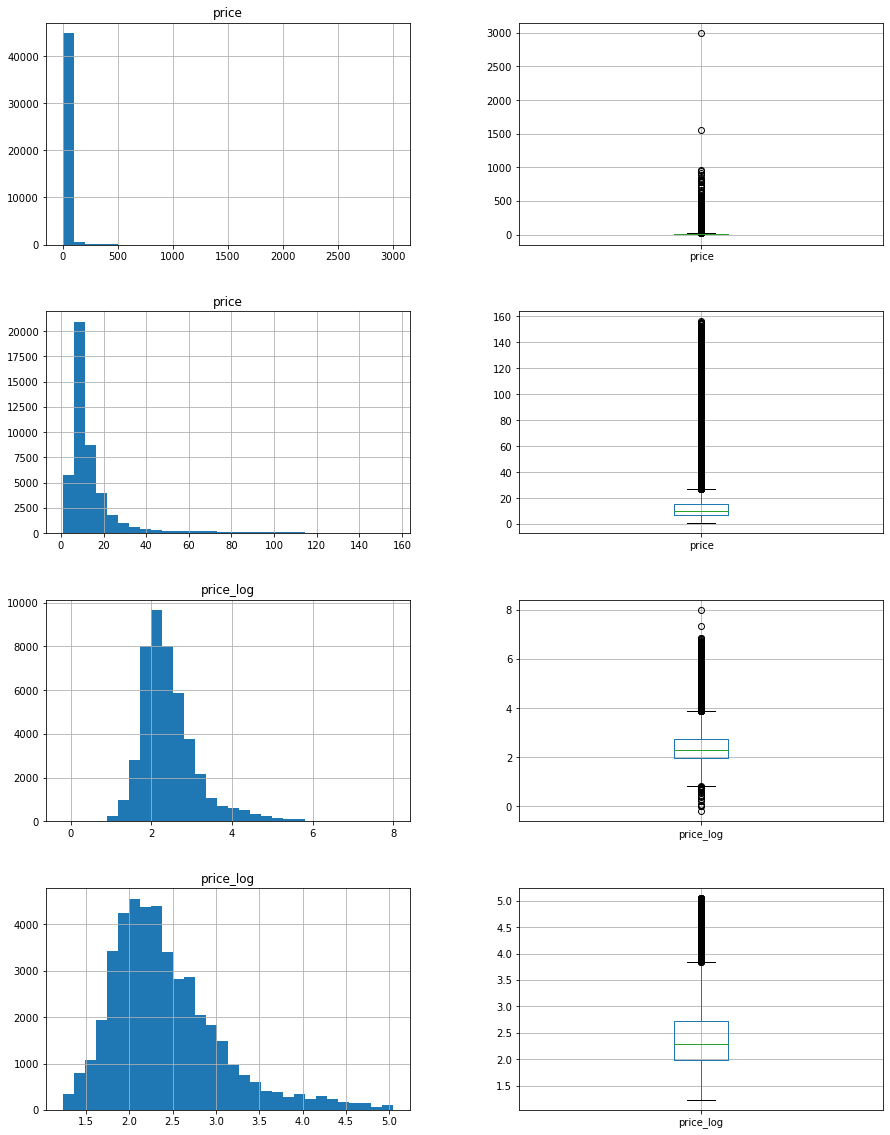

In [82]:
df_train['price_log'] = np.log( df_train['price'] )

plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 20))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=30, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(df_train, 'price', ax1, ax2)
sub_plot(df_train[ train.price < np.percentile( df_train.price, 99 ) ], 'price', ax3, ax4)
sub_plot(df_train, 'price_log', ax5, ax6)
sub_plot(df_train[ (df_train.price_log > np.percentile( df_train.price_log, 1 )) & (df_train.price_log < np.percentile( df_train.price_log, 99 )) ], 'price_log', ax7, ax8)

# Helpful functions

In [83]:
shift = 1
def mae_log_eval(y_log_pred, dtrain):
    y_log_true = dtrain.get_label()
        
    y_true =  np.exp(y_log_true) - shift
    y_pred = np.exp(y_log_pred) - shift
    
    return 'mae', mean_absolute_error(y_true, y_pred)

In [84]:
def cv(df, feats, model,  shift=1, folds=3, verbose=False, early_stopping_rounds=5, return_model=False):
    X = df[ feats ].values
    y = df['price'].values
    y_log = np.log( y + shift )
    
    cv = KFold(n_splits=3, shuffle=True, random_state=2019)

    scores = []
    train_evals, test_evals = [], []
    for train_idx, test_idx in tqdm( cv.split(X) ):

        eval_set = [ (X[train_idx], y_log[train_idx]), (X[test_idx], y_log[test_idx]),  ]
        model.fit(X[train_idx], y_log[train_idx], eval_metric=mae_log_eval, eval_set=eval_set, verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        y_pred_log = model.predict(X[test_idx])
        y_pred_log[ y_pred_log < 0 ] = 1e-6
        y_pred = np.exp( y_pred_log ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
        
        evals_result = model.evals_result()
        
    if return_model:
        return model, np.mean(scores), np.std(scores)
    
    return np.mean(scores), np.std(scores)

In [85]:
def fair_obj(y_true, y_pred):
    x = y_pred - y_true
    
    fair_constant = 0.7
    
    den = abs(x) + fair_constant
    
    grad = fair_constant * x / (den)
    hess = (fair_constant * fair_constant) / (den * den)
    
    return grad, hess

# X & y

In [114]:
X_train, X_test = df_train[feats].values, df_test[feats].values
y_train = df_train["price"].values
y_log_train = np.log(y_train)

# Model train & predict

In [87]:
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.2,
    'random_state': 0,
    'objective': fair_obj
}

cv(df_train, feats, xgb.XGBRegressor(**params), shift=2, folds=4)

3it [00:05,  1.90s/it]


(5.231233379211873, 0.02668070611414345)

# Learning_curve

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

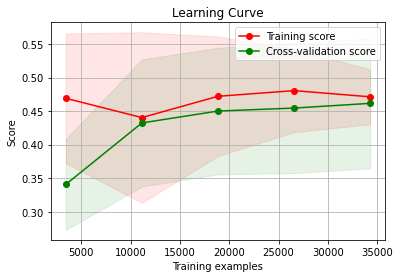

In [88]:
plot_learning_curve(xgb.XGBRegressor(**params), X_train, y_train, cv=4, random_state=0, shuffle=True)

# Hyperparameter optimization

In [90]:
def objective(space):
    
    params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 0,
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 200,
        'objective': fair_obj,
    }
    
    print(params)
    
    feats = [x for x in df.columns if "_cat" in x] 
    mean_score, std_score = cv(df_train, feats, xgb.XGBRegressor(**params), shift=2, folds=4)
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'shift': hp.quniform ('x_shift', 1, 200, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)
%time

{'max_depth': 12, 'colsample_bytree': 0.5346782016536387, 'learning_rate': 0.1606958580502032, 'subsample': 0.8802818490714144, 'seed': 0, 'min_child_weight': 20, 'reg_alpha': 1.0198685314910196, 'reg_lambda': 0.7021278256230462, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

0it [00:00, ?it/s]

1it [00:05,  5.02s/it]

2it [00:10,  5.25s/it]

3it [00:17,  5.65s/it]

3it [00:17,  5.79s/it]


score:                                                                                                                 
5.231719261498655                                                                                                      
0.029106239537823438                                                                                                   
{'max_depth': 12, 'colsample_bytree': 0.5161449291851817, 'learning_rate': 0.173861184588478, 'subsample': 0.9084045450090279, 'seed': 0, 'min_child_weight': 10, 'reg_alpha': 1.008385382217803, 'reg_lambda': 0.7214676807864646, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
  3%|█▋                                                | 1/30 [00:17<08:25, 17.42s/trial, best loss: 5.231719261498655]

0it [00:00, ?it/s]

1it [00:03,  3.76s/it]

2it [00:10,  4.56s/it]

3it [00:15,  4.68s/it]

3it [00:15,  5.05s/it]


score:                                                                                                                 
5.212027634076342                                                                                                      
0.0495991646745528                                                                                                     
{'max_depth': 18, 'colsample_bytree': 0.22804595503854397, 'learning_rate': 0.19208967245808234, 'subsample': 0.9990814316577704, 'seed': 0, 'min_child_weight': 20, 'reg_alpha': 1.0024098229206873, 'reg_lambda': 0.9166962348893978, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
  7%|███▎                                              | 2/30 [00:32<07:49, 16.76s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:06,  6.23s/it]

2it [00:12,  6.20s/it]

3it [00:18,  6.24s/it]

3it [00:18,  6.23s/it]


score:                                                                                                                 
5.3560636619135416                                                                                                     
0.0702205816591277                                                                                                     
{'max_depth': 5, 'colsample_bytree': 0.9671277837510012, 'learning_rate': 0.061452690504171154, 'subsample': 0.6326689214694503, 'seed': 0, 'min_child_weight': 190, 'reg_alpha': 2.5932645059479635, 'reg_lambda': 0.7057830441876658, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 10%|█████                                             | 3/30 [00:51<07:48, 17.37s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:04,  4.80s/it]

2it [00:10,  4.92s/it]

3it [00:14,  4.85s/it]

3it [00:14,  4.90s/it]


score:                                                                                                                 
6.427600714930057                                                                                                      
0.0976352451968743                                                                                                     
{'max_depth': 10, 'colsample_bytree': 0.7370532591291018, 'learning_rate': 0.0992718867472287, 'subsample': 0.7219673795390799, 'seed': 0, 'min_child_weight': 100, 'reg_alpha': 1.5310532135653132, 'reg_lambda': 0.7962841148103018, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 13%|██████▋                                           | 4/30 [01:06<07:11, 16.59s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:06,  6.57s/it]

2it [00:12,  6.35s/it]

3it [00:17,  6.08s/it]

3it [00:17,  5.95s/it]


score:                                                                                                                 
5.62028487009522                                                                                                       
0.07721236549751016                                                                                                    
{'max_depth': 20, 'colsample_bytree': 0.23770764390032767, 'learning_rate': 0.13988655548479137, 'subsample': 0.9925986923261002, 'seed': 0, 'min_child_weight': 90, 'reg_alpha': 1.5313147334611823, 'reg_lambda': 0.8232186798595957, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 17%|████████▎                                         | 5/30 [01:24<07:04, 16.99s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:05,  5.08s/it]

2it [00:10,  5.06s/it]

3it [00:15,  5.07s/it]

3it [00:15,  5.06s/it]


score:                                                                                                                 
5.572043026301252                                                                                                      
0.09358786897296084                                                                                                    
{'max_depth': 6, 'colsample_bytree': 0.5184638273854817, 'learning_rate': 0.1985774884914551, 'subsample': 0.8609214911648855, 'seed': 0, 'min_child_weight': 190, 'reg_alpha': 2.2421292900721985, 'reg_lambda': 0.9706043049320522, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 20%|██████████                                        | 6/30 [01:39<06:35, 16.48s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:03,  3.70s/it]

2it [00:07,  3.75s/it]

3it [00:11,  3.78s/it]

3it [00:11,  3.81s/it]


score:                                                                                                                 
5.858427765746998                                                                                                      
0.08180368188817862                                                                                                    
{'max_depth': 16, 'colsample_bytree': 0.8425107601160188, 'learning_rate': 0.09875974146114827, 'subsample': 0.7622125200205404, 'seed': 0, 'min_child_weight': 50, 'reg_alpha': 1.240901723436173, 'reg_lambda': 0.7448214401479333, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 23%|███████████▋                                      | 7/30 [01:50<05:44, 14.99s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:09,  9.23s/it]

2it [00:17,  9.05s/it]

3it [00:26,  8.91s/it]

3it [00:26,  8.82s/it]


score:                                                                                                                 
5.258060468504319                                                                                                      
0.06651716551107932                                                                                                    
{'max_depth': 9, 'colsample_bytree': 0.3928981787654361, 'learning_rate': 0.17325320889749932, 'subsample': 0.9246465584415926, 'seed': 0, 'min_child_weight': 160, 'reg_alpha': 1.9152256788580588, 'reg_lambda': 0.8829047968479597, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 27%|█████████████▎                                    | 8/30 [02:17<06:45, 18.45s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:04,  4.15s/it]

2it [00:08,  4.15s/it]

3it [00:12,  4.15s/it]

3it [00:12,  4.15s/it]


score:                                                                                                                 
5.67069256759896                                                                                                       
0.07986748334914495                                                                                                    
{'max_depth': 16, 'colsample_bytree': 0.7181923485217088, 'learning_rate': 0.11897944928254882, 'subsample': 0.6125746344591207, 'seed': 0, 'min_child_weight': 60, 'reg_alpha': 1.2626303856772765, 'reg_lambda': 0.7618107806081296, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 30%|███████████████                                   | 9/30 [02:30<05:50, 16.68s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:07,  7.66s/it]

2it [00:16,  7.90s/it]

3it [00:24,  8.09s/it]

3it [00:24,  8.22s/it]


score:                                                                                                                 
5.358349563918325                                                                                                      
0.05906979513629891                                                                                                    
{'max_depth': 14, 'colsample_bytree': 0.35235815482169675, 'learning_rate': 0.05088781614708364, 'subsample': 0.6711072325579158, 'seed': 0, 'min_child_weight': 140, 'reg_alpha': 1.2225163061638646, 'reg_lambda': 0.9488321691865043, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 33%|████████████████▎                                | 10/30 [02:54<06:21, 19.10s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:05,  5.09s/it]

2it [00:10,  5.07s/it]

3it [00:15,  5.07s/it]

3it [00:15,  5.07s/it]


score:                                                                                                                 
6.140429542176541                                                                                                      
0.13522989878934813                                                                                                    
{'max_depth': 8, 'colsample_bytree': 0.9783143212281801, 'learning_rate': 0.15442690845195323, 'subsample': 0.8034288189391429, 'seed': 0, 'min_child_weight': 60, 'reg_alpha': 1.865211099474739, 'reg_lambda': 0.8529210889456655, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 37%|█████████████████▉                               | 11/30 [03:10<05:41, 17.96s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:05,  5.69s/it]

2it [00:11,  5.68s/it]

3it [00:17,  5.69s/it]

3it [00:17,  5.68s/it]


score:                                                                                                                 
5.373284641305413                                                                                                      
0.04800303537573781                                                                                                    
{'max_depth': 12, 'colsample_bytree': 0.6661790597047013, 'learning_rate': 0.07366851586553548, 'subsample': 0.8212516203487911, 'seed': 0, 'min_child_weight': 130, 'reg_alpha': 1.0052014387800554, 'reg_lambda': 0.7536376966260485, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 40%|███████████████████▌                             | 12/30 [03:27<05:18, 17.71s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:06,  6.02s/it]

2it [00:12,  6.05s/it]

3it [00:18,  6.05s/it]

3it [00:18,  6.06s/it]


score:                                                                                                                 
5.713963075495323                                                                                                      
0.07308061881426149                                                                                                    
{'max_depth': 7, 'colsample_bytree': 0.4210221818435539, 'learning_rate': 0.18152776959968397, 'subsample': 0.9334514100867576, 'seed': 0, 'min_child_weight': 10, 'reg_alpha': 2.6801967787937353, 'reg_lambda': 0.995599280192998, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 43%|█████████████████████▏                           | 13/30 [03:45<05:03, 17.88s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:04,  4.47s/it]

2it [00:08,  4.45s/it]

3it [00:13,  4.38s/it]

3it [00:13,  4.36s/it]


score:                                                                                                                 
5.338671105724006                                                                                                      
0.061547598761559554                                                                                                   
{'max_depth': 19, 'colsample_bytree': 0.8180347797621607, 'learning_rate': 0.12250818238571329, 'subsample': 0.9442242431281384, 'seed': 0, 'min_child_weight': 40, 'reg_alpha': 1.1251582610299404, 'reg_lambda': 0.7067146335325464, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 47%|██████████████████████▊                          | 14/30 [03:58<04:23, 16.47s/trial, best loss: 5.212027634076342]

0it [00:00, ?it/s]

1it [00:08,  8.06s/it]

2it [00:17,  8.58s/it]

3it [00:27,  8.90s/it]

3it [00:27,  9.16s/it]


score:                                                                                                                 
5.165721079357297                                                                                                      
0.03439598232125591                                                                                                    
{'max_depth': 20, 'colsample_bytree': 0.8589212057437375, 'learning_rate': 0.12078494280427622, 'subsample': 0.9710617875900216, 'seed': 0, 'min_child_weight': 40, 'reg_alpha': 1.387795407290286, 'reg_lambda': 0.8021594328497386, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 50%|████████████████████████▌                        | 15/30 [04:26<04:57, 19.81s/trial, best loss: 5.165721079357297]

0it [00:00, ?it/s]

1it [00:09,  9.89s/it]

2it [00:21, 10.30s/it]

3it [00:32, 10.47s/it]

3it [00:32, 10.67s/it]


score:                                                                                                                 
5.153033810550377                                                                                                      
0.025350548761756568                                                                                                   
{'max_depth': 17, 'colsample_bytree': 0.8831327509390207, 'learning_rate': 0.08850232478095645, 'subsample': 0.9825166128499849, 'seed': 0, 'min_child_weight': 80, 'reg_alpha': 1.400146378212329, 'reg_lambda': 0.7950428728817421, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 53%|██████████████████████████▏                      | 16/30 [04:58<05:28, 23.49s/trial, best loss: 5.153033810550377]

0it [00:00, ?it/s]

1it [00:08,  8.57s/it]

2it [00:18,  8.85s/it]

3it [00:27,  9.04s/it]

3it [00:27,  9.19s/it]


score:                                                                                                                 
5.295300139885197                                                                                                      
0.040492365772930576                                                                                                   
{'max_depth': 20, 'colsample_bytree': 0.8298072810394155, 'learning_rate': 0.12541812430599955, 'subsample': 0.9615121365637275, 'seed': 0, 'min_child_weight': 40, 'reg_alpha': 1.130879908544096, 'reg_lambda': 0.8550730447122055, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 57%|███████████████████████████▊                     | 17/30 [05:26<05:21, 24.74s/trial, best loss: 5.153033810550377]

0it [00:00, ?it/s]

1it [00:09,  9.79s/it]

2it [00:21, 10.27s/it]

3it [00:32, 10.62s/it]

3it [00:32, 10.88s/it]


score:                                                                                                                 
5.136497620250503                                                                                                      
0.029077833631376327                                                                                                   
{'max_depth': 20, 'colsample_bytree': 0.9132233883961781, 'learning_rate': 0.13556614558240487, 'subsample': 0.9606815329674844, 'seed': 0, 'min_child_weight': 40, 'reg_alpha': 1.380064861949109, 'reg_lambda': 0.8664846246139659, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 60%|█████████████████████████████▍                   | 18/30 [05:58<05:25, 27.14s/trial, best loss: 5.136497620250503]

0it [00:00, ?it/s]

1it [00:07,  7.42s/it]

2it [00:17,  8.21s/it]

3it [00:29,  9.49s/it]

3it [00:29,  9.98s/it]


score:                                                                                                                 
5.130263544171526                                                                                                      
0.032515879034229395                                                                                                   
{'max_depth': 19, 'colsample_bytree': 0.9894540449944669, 'learning_rate': 0.1400266632201972, 'subsample': 0.8682258488576093, 'seed': 0, 'min_child_weight': 70, 'reg_alpha': 1.7549804608825728, 'reg_lambda': 0.877406440575852, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 63%|███████████████████████████████                  | 19/30 [06:28<05:07, 28.00s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:10, 10.71s/it]

2it [00:22, 10.93s/it]

3it [00:34, 11.39s/it]

3it [00:34, 11.54s/it]


score:                                                                                                                 
5.217196868524532                                                                                                      
0.04213210420914335                                                                                                    
{'max_depth': 14, 'colsample_bytree': 0.9263659209459467, 'learning_rate': 0.13911382623414487, 'subsample': 0.838454908787665, 'seed': 0, 'min_child_weight': 30, 'reg_alpha': 1.1197509881904943, 'reg_lambda': 0.9147879446365245, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 67%|████████████████████████████████▋                | 20/30 [07:03<05:00, 30.01s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:09,  9.54s/it]

2it [00:17,  9.16s/it]

3it [00:23,  8.18s/it]

3it [00:23,  7.90s/it]


score:                                                                                                                 
5.140388203530109                                                                                                      
0.05454140885935444                                                                                                    
{'max_depth': 18, 'colsample_bytree': 0.7749963152507683, 'learning_rate': 0.10861117353321853, 'subsample': 0.8956561715550643, 'seed': 0, 'min_child_weight': 110, 'reg_alpha': 1.398600620387261, 'reg_lambda': 0.8343655258388032, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 70%|██████████████████████████████████▎              | 21/30 [07:27<04:13, 28.15s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:09,  9.34s/it]

2it [00:18,  9.29s/it]

3it [00:27,  9.16s/it]

3it [00:27,  9.12s/it]


score:                                                                                                                 
5.376371067556175                                                                                                      
0.06360872956503726                                                                                                    
{'max_depth': 15, 'colsample_bytree': 0.6363194761921953, 'learning_rate': 0.14786703248704797, 'subsample': 0.9554467190876463, 'seed': 0, 'min_child_weight': 80, 'reg_alpha': 1.1503900606118511, 'reg_lambda': 0.8736638023223271, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 73%|███████████████████████████████████▉             | 22/30 [07:54<03:43, 27.94s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:07,  7.39s/it]

2it [00:15,  7.52s/it]

3it [00:22,  7.51s/it]

3it [00:22,  7.57s/it]


score:                                                                                                                 
5.287401307838241                                                                                                      
0.042552222027177546                                                                                                   
{'max_depth': 19, 'colsample_bytree': 0.9207608298710689, 'learning_rate': 0.12991229157128273, 'subsample': 0.7579425064237703, 'seed': 0, 'min_child_weight': 120, 'reg_alpha': 1.5341349832825906, 'reg_lambda': 0.9229400673690153, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 77%|█████████████████████████████████████▌           | 23/30 [08:17<03:04, 26.39s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:10, 10.15s/it]

2it [00:19, 10.00s/it]

3it [00:29,  9.89s/it]

3it [00:29,  9.81s/it]


score:                                                                                                                 
5.386722576096537                                                                                                      
0.05470205261195236                                                                                                    
{'max_depth': 17, 'colsample_bytree': 0.780292835732174, 'learning_rate': 0.08759876963077726, 'subsample': 0.9936844625557307, 'seed': 0, 'min_child_weight': 40, 'reg_alpha': 1.3010518684609051, 'reg_lambda': 0.8511111331182406, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 80%|███████████████████████████████████████▏         | 24/30 [08:47<02:43, 27.33s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:08,  8.73s/it]

2it [00:18,  8.92s/it]

3it [00:27,  9.00s/it]

3it [00:27,  9.10s/it]


score:                                                                                                                 
5.215323947689616                                                                                                      
0.04860882233071582                                                                                                    
{'max_depth': 20, 'colsample_bytree': 0.6867961034261457, 'learning_rate': 0.11003309427714221, 'subsample': 0.8447563675045964, 'seed': 0, 'min_child_weight': 60, 'reg_alpha': 1.096709822897361, 'reg_lambda': 0.8938706597110524, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 83%|████████████████████████████████████████▊        | 25/30 [09:14<02:16, 27.35s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:08,  9.00s/it]

2it [00:17,  8.90s/it]

3it [00:26,  8.81s/it]

3it [00:26,  8.76s/it]


score:                                                                                                                 
5.245104528072869                                                                                                      
0.04965099234165302                                                                                                    
{'max_depth': 14, 'colsample_bytree': 0.5904349906957755, 'learning_rate': 0.16047593345462366, 'subsample': 0.9112455439354662, 'seed': 0, 'min_child_weight': 20, 'reg_alpha': 1.6186890303156372, 'reg_lambda': 0.8244895544767679, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 87%|██████████████████████████████████████████▍      | 26/30 [09:40<01:48, 27.06s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:06,  6.34s/it]

2it [00:12,  6.15s/it]

3it [00:19,  6.52s/it]

3it [00:19,  6.47s/it]


score:                                                                                                                 
5.199161159931756                                                                                                      
0.022156610278627167                                                                                                   
{'max_depth': 18, 'colsample_bytree': 0.9114744346590619, 'learning_rate': 0.1300320654804414, 'subsample': 0.765390581194276, 'seed': 0, 'min_child_weight': 150, 'reg_alpha': 2.0934684687831635, 'reg_lambda': 0.9437927908262003, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 90%|████████████████████████████████████████████     | 27/30 [10:00<01:14, 24.79s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:09,  9.72s/it]

2it [00:19,  9.77s/it]

3it [00:29,  9.84s/it]

3it [00:29,  9.87s/it]


score:                                                                                                                 
5.483313460586914                                                                                                      
0.058304211413525535                                                                                                   
{'max_depth': 11, 'colsample_bytree': 0.5730738607547783, 'learning_rate': 0.1675229218725118, 'subsample': 0.8848243352491056, 'seed': 0, 'min_child_weight': 30, 'reg_alpha': 1.3376530511340874, 'reg_lambda': 0.8642269930186431, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 93%|█████████████████████████████████████████████▋   | 28/30 [10:30<00:52, 26.27s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:06,  6.14s/it]

2it [00:11,  5.89s/it]

3it [00:17,  6.07s/it]

3it [00:17,  5.98s/it]


score:                                                                                                                 
5.242078571790594                                                                                                      
0.02298005705538958                                                                                                    
{'max_depth': 16, 'colsample_bytree': 0.8077301040620908, 'learning_rate': 0.15270059088198543, 'subsample': 0.9634370026211647, 'seed': 0, 'min_child_weight': 170, 'reg_alpha': 1.0689874748038328, 'reg_lambda': 0.8971636619362352, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 97%|███████████████████████████████████████████████▎ | 29/30 [10:48<00:23, 23.80s/trial, best loss: 5.130263544171526]

0it [00:00, ?it/s]

1it [00:08,  8.49s/it]

2it [00:17,  8.50s/it]

3it [00:25,  8.54s/it]

3it [00:25,  8.55s/it]


score:                                                                                                                 
5.432262532966128                                                                                                      
0.0578574672078125                                                                                                     
100%|█████████████████████████████████████████████████| 30/30 [11:13<00:00, 22.46s/trial, best loss: 5.130263544171526]
The best params:  {'x_colsample_bytree': 0.9132233883961781, 'x_learning_rate': 0.13556614558240487, 'x_max_depth': 20.0, 'x_min_child_weight': 40.0, 'x_reg_alpha': 1.380064861949109, 'x_reg_lambda': 0.8664846246139659, 'x_seed': 1650.0, 'x_shift': 92.0, 'x_subsample': 0.9606815329674844}
Wall time: 0 ns


In [91]:
trials.best_trial

{'state': 2,
 'tid': 18,
 'spec': None,
 'result': {'loss': 5.130263544171526, 'status': 'ok'},
 'misc': {'tid': 18,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [18],
   'x_learning_rate': [18],
   'x_max_depth': [18],
   'x_min_child_weight': [18],
   'x_reg_alpha': [18],
   'x_reg_lambda': [18],
   'x_seed': [18],
   'x_shift': [18],
   'x_subsample': [18]},
  'vals': {'x_colsample_bytree': [0.9132233883961781],
   'x_learning_rate': [0.13556614558240487],
   'x_max_depth': [20.0],
   'x_min_child_weight': [40.0],
   'x_reg_alpha': [1.380064861949109],
   'x_reg_lambda': [0.8664846246139659],
   'x_seed': [1650.0],
   'x_shift': [92.0],
   'x_subsample': [0.9606815329674844]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 5, 16, 15, 41, 50, 111000),
 'refresh_time': datetime.datetime(2021, 5, 16, 15, 42, 20, 81000)}

In [115]:
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.14,
    'subsample': 0.96,
    'random_state': 1650,
    'objective': fair_obj
}

cv(df_train, feats, xgb.XGBRegressor(**params), shift=2, folds=4)

3it [00:09,  3.25s/it]


(5.119092721770341, 0.01095694071776856)

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

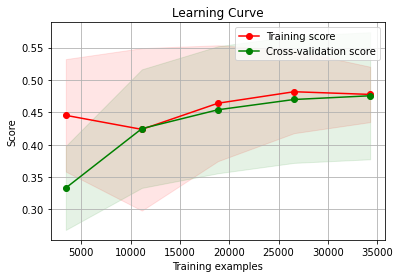

In [93]:
plot_learning_curve(xgb.XGBRegressor(**params), X_train, y_train, cv=4, random_state=0, shuffle=True)

In [116]:
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

C:\Users\elzbi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


# Submission

In [117]:
output = pd.DataFrame({'id': test['id'], 'price': y_pred})
output.to_csv('./output/model_XGBRegressor_all.csv', index=False)

# Feature importances

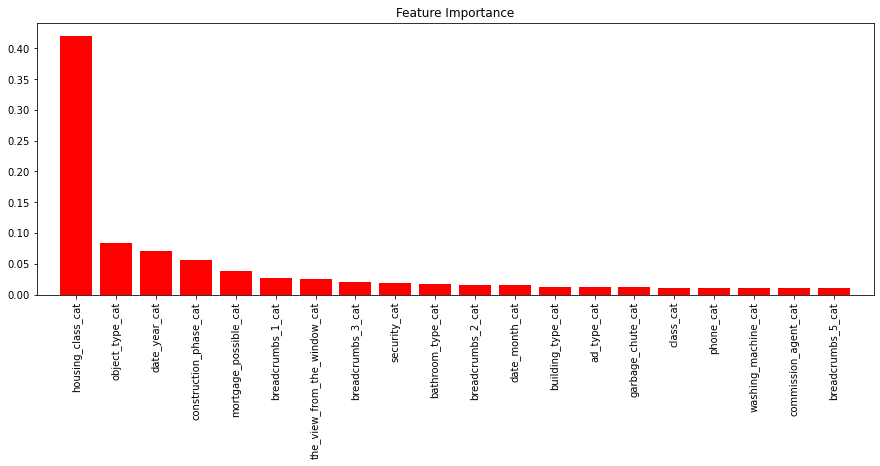

In [95]:
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5));

# Alternative feats selection

In [155]:
feats = ['date_month_cat', 'date_year_cat', 'security_cat', 'building_type_cat', 'object_type_cat', 'ad_type_cat', 'commission_agent_cat', 'construction_phase_cat', 'housing_class_cat', 'elevator_cat', 'bathroom_type_cat', 'balcony_type_cat', 'mortgage_possible_cat', 'the_view_from_the_window_cat', 'garbage_chute_cat', 'repair_cat', 'fridge_cat', 'phone_cat', 'furniture_cat', 'free_layout_cat', 'it_is_possible_to_bargain_cat', 'floor_covering_cat', 'room_type_cat', 'internet_cat', 'kitchen_furniture_cat', 'tv_cat', 'washing_machine_cat', 'foundation_type_cat', 'overlap_type_cat', 'type_of_the_building_cat', 'playground_cat', 'class_cat', 'breadcrumbs_0_cat', 'breadcrumbs_1_cat', 'breadcrumbs_2_cat', 'breadcrumbs_3_cat', 'breadcrumbs_4_cat', 'breadcrumbs_5_cat', 'breadcrumbs_6_cat', 'breadcrumbs_7_cat']

In [156]:
X_train, X_test = df_train[feats].values, df_test[feats].values
y_train = df_train["price"].values
y_log_train = np.log(y_train)

In [157]:
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.14,
    'subsample': 0.96,
    'random_state': 1650,
    'objective': fair_obj
}

cv(df_train, feats, xgb.XGBRegressor(**params), shift=2, folds=4)

3it [00:06,  2.24s/it]


(5.15172661853394, 0.03763495344181744)

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

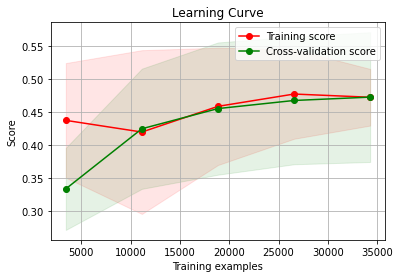

In [158]:
plot_learning_curve(xgb.XGBRegressor(**params), X_train, y_train, cv=4, random_state=0, shuffle=True)

In [159]:
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

C:\Users\elzbi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [160]:
output = pd.DataFrame({'id': test['id'], 'price': y_pred})
output.to_csv('./output/model_XGBRegressor_1.csv', index=False)

In [161]:
feats = ['security_cat', 'building_type_cat', 'object_type_cat', 'ad_type_cat', 'commission_agent_cat', 'construction_phase_cat', 'housing_class_cat', 'elevator_cat', 'bathroom_type_cat', 'balcony_type_cat', 'mortgage_possible_cat', 'the_view_from_the_window_cat', 'garbage_chute_cat', 'repair_cat', 'fridge_cat', 'phone_cat', 'furniture_cat', 'free_layout_cat', 'it_is_possible_to_bargain_cat', 'floor_covering_cat', 'room_type_cat', 'internet_cat', 'kitchen_furniture_cat', 'tv_cat', 'washing_machine_cat', 'foundation_type_cat', 'overlap_type_cat', 'type_of_the_building_cat', 'playground_cat', 'class_cat', 'breadcrumbs_0_cat', 'breadcrumbs_1_cat', 'breadcrumbs_2_cat', 'breadcrumbs_3_cat', 'breadcrumbs_4_cat', 'breadcrumbs_5_cat', 'breadcrumbs_6_cat', 'breadcrumbs_7_cat']

In [162]:
X_train, X_test = df_train[feats].values, df_test[feats].values
y_train = df_train["price"].values
y_log_train = np.log(y_train)

In [163]:
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.14,
    'subsample': 0.96,
    'random_state': 1650,
    'objective': fair_obj
}

cv(df_train, feats, xgb.XGBRegressor(**params), shift=2, folds=4)

3it [00:09,  3.09s/it]


(5.145567878300796, 0.050544346800855545)

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

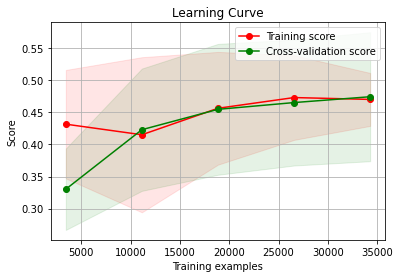

In [164]:
plot_learning_curve(xgb.XGBRegressor(**params), X_train, y_train, cv=4, random_state=0, shuffle=True)

In [165]:
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

C:\Users\elzbi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [166]:
output = pd.DataFrame({'id': test['id'], 'price': y_pred})
output.to_csv('./output/model_XGBRegressor_2.csv', index=False)

In [167]:
def objective(space):
    
    params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 0,
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 200,
        'objective': fair_obj,
    }
    
    print(params)
    
    feats = feats = ['security_cat', 'building_type_cat', 'object_type_cat', 
                     'ad_type_cat', 'commission_agent_cat', 'construction_phase_cat', 
                     'housing_class_cat', 'elevator_cat', 'bathroom_type_cat', 'balcony_type_cat', 
                     'mortgage_possible_cat', 'the_view_from_the_window_cat', 'garbage_chute_cat', 
                     'repair_cat', 'fridge_cat', 'phone_cat', 'furniture_cat', 'free_layout_cat', 
                     'it_is_possible_to_bargain_cat', 'floor_covering_cat', 'room_type_cat', 'internet_cat', 
                     'kitchen_furniture_cat', 'tv_cat', 'washing_machine_cat', 'foundation_type_cat', 
                     'overlap_type_cat', 'type_of_the_building_cat', 'playground_cat', 'class_cat', 
                     'breadcrumbs_0_cat', 'breadcrumbs_1_cat', 'breadcrumbs_2_cat', 'breadcrumbs_3_cat', 
                     'breadcrumbs_4_cat', 'breadcrumbs_5_cat', 'breadcrumbs_6_cat', 'breadcrumbs_7_cat']
    mean_score, std_score = cv(df_train, feats, xgb.XGBRegressor(**params), shift=2, folds=4)
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'shift': hp.quniform ('x_shift', 1, 200, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)
%time

{'max_depth': 19, 'colsample_bytree': 0.7508690213216382, 'learning_rate': 0.09344547186107552, 'subsample': 0.8706773142161324, 'seed': 0, 'min_child_weight': 160, 'reg_alpha': 1.604250580340005, 'reg_lambda': 0.8817908575604276, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

0it [00:00, ?it/s]

1it [00:07,  7.15s/it]

2it [00:14,  7.09s/it]

3it [00:21,  7.05s/it]

3it [00:21,  7.02s/it]


score:                                                                                                                 
5.624337007758779                                                                                                      
0.04803513741523668                                                                                                    
{'max_depth': 20, 'colsample_bytree': 0.8156513005099715, 'learning_rate': 0.07632230077654, 'subsample': 0.8969164320059989, 'seed': 0, 'min_child_weight': 180, 'reg_alpha': 1.4963621233793174, 'reg_lambda': 0.8929183510158195, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
  3%|█▋                                                | 1/30 [00:21<10:11, 21.10s/trial, best loss: 5.624337007758779]

0it [00:00, ?it/s]

1it [00:07,  7.09s/it]

2it [00:14,  7.10s/it]

3it [00:21,  7.11s/it]

3it [00:21,  7.12s/it]


score:                                                                                                                 
5.731371499288522                                                                                                      
0.08746064549316235                                                                                                    
{'max_depth': 10, 'colsample_bytree': 0.20788935526786834, 'learning_rate': 0.19402428724307424, 'subsample': 0.617999885063513, 'seed': 0, 'min_child_weight': 40, 'reg_alpha': 2.4496546917380644, 'reg_lambda': 0.7012948294917657, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
  7%|███▎                                              | 2/30 [00:42<09:53, 21.19s/trial, best loss: 5.624337007758779]

0it [00:00, ?it/s]

1it [00:03,  3.39s/it]

2it [00:06,  3.37s/it]

3it [00:09,  3.34s/it]

3it [00:09,  3.33s/it]


score:                                                                                                                 
5.728016238784314                                                                                                      
0.08258344953041413                                                                                                    
{'max_depth': 20, 'colsample_bytree': 0.4258626387387887, 'learning_rate': 0.13300461864811453, 'subsample': 0.9905777685271602, 'seed': 0, 'min_child_weight': 200, 'reg_alpha': 1.1324983223449165, 'reg_lambda': 0.9726336412075833, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 10%|█████                                             | 3/30 [00:52<08:02, 17.85s/trial, best loss: 5.624337007758779]

0it [00:00, ?it/s]

1it [00:04,  4.93s/it]

2it [00:09,  4.92s/it]

3it [00:14,  4.91s/it]

3it [00:14,  4.90s/it]


score:                                                                                                                 
5.647079635172939                                                                                                      
0.04965565231299155                                                                                                    
{'max_depth': 16, 'colsample_bytree': 0.9750611037406427, 'learning_rate': 0.06428826325628442, 'subsample': 0.7112989292839241, 'seed': 0, 'min_child_weight': 110, 'reg_alpha': 2.6763411307104374, 'reg_lambda': 0.7470293526441301, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 13%|██████▋                                           | 4/30 [01:07<07:20, 16.93s/trial, best loss: 5.624337007758779]

0it [00:00, ?it/s]

1it [00:07,  7.46s/it]

2it [00:14,  7.48s/it]

3it [00:22,  7.53s/it]

3it [00:22,  7.54s/it]


score:                                                                                                                 
5.690907998628252                                                                                                      
0.08392528266949034                                                                                                    
{'max_depth': 7, 'colsample_bytree': 0.64840667378178, 'learning_rate': 0.12936398625059697, 'subsample': 0.8277909685663185, 'seed': 0, 'min_child_weight': 130, 'reg_alpha': 1.8083388788226455, 'reg_lambda': 0.8237060189115877, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 17%|████████▎                                         | 5/30 [01:30<07:46, 18.66s/trial, best loss: 5.624337007758779]

0it [00:00, ?it/s]

1it [00:03,  3.80s/it]

2it [00:07,  3.80s/it]

3it [00:11,  3.80s/it]

3it [00:11,  3.81s/it]


score:                                                                                                                 
5.692203593118305                                                                                                      
0.040875913448769285                                                                                                   
{'max_depth': 14, 'colsample_bytree': 0.9915020203456015, 'learning_rate': 0.1895459632543109, 'subsample': 0.9891733346016846, 'seed': 0, 'min_child_weight': 20, 'reg_alpha': 1.0074677549135966, 'reg_lambda': 0.9920048600278328, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 20%|██████████                                        | 6/30 [01:41<06:36, 16.51s/trial, best loss: 5.624337007758779]

0it [00:00, ?it/s]

1it [00:04,  4.15s/it]

2it [00:12,  5.26s/it]

3it [00:18,  5.57s/it]

3it [00:18,  6.10s/it]


score:                                                                                                                 
5.124369205141581                                                                                                      
0.061094542195969055                                                                                                   
{'max_depth': 14, 'colsample_bytree': 0.9591415989776472, 'learning_rate': 0.19438045308796537, 'subsample': 0.9827698665667021, 'seed': 0, 'min_child_weight': 20, 'reg_alpha': 1.005508396636912, 'reg_lambda': 0.9968321252999163, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 23%|███████████▋                                      | 7/30 [01:59<06:32, 17.07s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:04,  4.03s/it]

2it [00:10,  4.63s/it]

3it [00:15,  4.77s/it]

3it [00:15,  5.06s/it]


score:                                                                                                                 
5.132975247640672                                                                                                      
0.04911121237738326                                                                                                    
{'max_depth': 5, 'colsample_bytree': 0.39693331291068723, 'learning_rate': 0.16780737328647913, 'subsample': 0.7595549446367814, 'seed': 0, 'min_child_weight': 60, 'reg_alpha': 1.2260466972212336, 'reg_lambda': 0.9388321816763182, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 27%|█████████████▎                                    | 8/30 [02:15<06:03, 16.53s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:03,  3.09s/it]

2it [00:06,  3.09s/it]

3it [00:09,  3.10s/it]

3it [00:09,  3.10s/it]


score:                                                                                                                 
5.790350067041697                                                                                                      
0.08853520295803624                                                                                                    
{'max_depth': 10, 'colsample_bytree': 0.9860656223543547, 'learning_rate': 0.16171366822285796, 'subsample': 0.9510358622843067, 'seed': 0, 'min_child_weight': 70, 'reg_alpha': 2.064217921126283, 'reg_lambda': 0.7899412662823246, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 30%|███████████████                                   | 9/30 [02:24<05:01, 14.38s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:05,  5.56s/it]

2it [00:11,  5.56s/it]

3it [00:16,  5.56s/it]

3it [00:16,  5.56s/it]


score:                                                                                                                 
5.313937014375714                                                                                                      
0.05013818008560757                                                                                                    
{'max_depth': 16, 'colsample_bytree': 0.501656932798759, 'learning_rate': 0.16829383943757623, 'subsample': 0.6310830469444347, 'seed': 0, 'min_child_weight': 20, 'reg_alpha': 1.3234675197785462, 'reg_lambda': 0.9498009537103194, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 33%|████████████████▎                                | 10/30 [02:41<05:01, 15.09s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:04,  4.44s/it]

2it [00:09,  4.73s/it]

3it [00:15,  5.12s/it]

3it [00:15,  5.29s/it]


score:                                                                                                                 
5.178405251685044                                                                                                      
0.044499507534277095                                                                                                   
{'max_depth': 11, 'colsample_bytree': 0.2060405852861638, 'learning_rate': 0.10346498620978296, 'subsample': 0.9171679793125729, 'seed': 0, 'min_child_weight': 80, 'reg_alpha': 1.027028974835996, 'reg_lambda': 0.906214178131326, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 37%|█████████████████▉                               | 11/30 [02:57<04:51, 15.35s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:03,  3.37s/it]

2it [00:06,  3.35s/it]

3it [00:09,  3.33s/it]

3it [00:09,  3.32s/it]


score:                                                                                                                 
5.889139566979463                                                                                                      
0.10121609059364813                                                                                                    
{'max_depth': 7, 'colsample_bytree': 0.8488013207058964, 'learning_rate': 0.19959894033414197, 'subsample': 0.700306533561287, 'seed': 0, 'min_child_weight': 10, 'reg_alpha': 2.0653875662582615, 'reg_lambda': 0.8233210768743754, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 40%|███████████████████▌                             | 12/30 [03:07<04:07, 13.76s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:03,  3.13s/it]

2it [00:06,  3.34s/it]

3it [00:11,  3.69s/it]

3it [00:11,  3.82s/it]


score:                                                                                                                 
5.245524588868244                                                                                                      
0.04298991344337015                                                                                                    
{'max_depth': 17, 'colsample_bytree': 0.6125378217141251, 'learning_rate': 0.14131340713315887, 'subsample': 0.8173145875535398, 'seed': 0, 'min_child_weight': 130, 'reg_alpha': 1.3731982300453647, 'reg_lambda': 0.9973551048524997, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 43%|█████████████████████▏                           | 13/30 [03:18<03:42, 13.10s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:06,  6.08s/it]

2it [00:12,  6.07s/it]

3it [00:18,  6.06s/it]

3it [00:18,  6.06s/it]


score:                                                                                                                 
5.4367313478158215                                                                                                     
0.04846414783300438                                                                                                    
{'max_depth': 13, 'colsample_bytree': 0.7066560878656032, 'learning_rate': 0.10460307840318546, 'subsample': 0.9984824213198453, 'seed': 0, 'min_child_weight': 90, 'reg_alpha': 1.0928023417464274, 'reg_lambda': 0.7056210236173169, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 47%|██████████████████████▊                          | 14/30 [03:37<03:54, 14.65s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:05,  5.61s/it]

2it [00:11,  5.63s/it]

3it [00:17,  5.79s/it]

3it [00:17,  5.81s/it]


score:                                                                                                                 
5.4188204656820815                                                                                                     
0.0677008978512528                                                                                                     
{'max_depth': 7, 'colsample_bytree': 0.9080649218932932, 'learning_rate': 0.15239077605220555, 'subsample': 0.7642515815230807, 'seed': 0, 'min_child_weight': 50, 'reg_alpha': 1.7646607816893558, 'reg_lambda': 0.85085504873942, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 50%|████████████████████████▌                        | 15/30 [03:54<03:52, 15.51s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:05,  5.03s/it]

2it [00:10,  5.09s/it]

3it [00:14,  4.95s/it]

3it [00:14,  4.96s/it]


score:                                                                                                                 
5.420437014918636                                                                                                      
0.053845779858446303                                                                                                   
{'max_depth': 18, 'colsample_bytree': 0.3162513475713165, 'learning_rate': 0.18173645920652032, 'subsample': 0.8612336682906798, 'seed': 0, 'min_child_weight': 110, 'reg_alpha': 1.2380590002560408, 'reg_lambda': 0.9310394714361043, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 53%|██████████████████████████▏                      | 16/30 [04:09<03:34, 15.34s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:04,  4.94s/it]

2it [00:10,  5.01s/it]

3it [00:14,  4.96s/it]

3it [00:14,  4.99s/it]


score:                                                                                                                 
5.485680758005176                                                                                                      
0.05764966471089897                                                                                                    
{'max_depth': 13, 'colsample_bytree': 0.9846874434050739, 'learning_rate': 0.18580861470353316, 'subsample': 0.9597678389954254, 'seed': 0, 'min_child_weight': 30, 'reg_alpha': 1.0084662912815487, 'reg_lambda': 0.9992434076913483, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 57%|███████████████████████████▊                     | 17/30 [04:24<03:18, 15.26s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:05,  5.21s/it]

2it [00:12,  5.70s/it]

3it [00:18,  5.78s/it]

3it [00:18,  6.01s/it]


score:                                                                                                                 
5.137250569756591                                                                                                      
0.04961645933439594                                                                                                    
{'max_depth': 14, 'colsample_bytree': 0.8830346045833731, 'learning_rate': 0.1966090416535322, 'subsample': 0.9960631305568088, 'seed': 0, 'min_child_weight': 10, 'reg_alpha': 1.0033117082112277, 'reg_lambda': 0.9750451630491972, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 60%|█████████████████████████████▍                   | 18/30 [04:42<03:13, 16.11s/trial, best loss: 5.124369205141581]

0it [00:00, ?it/s]

1it [00:02,  2.51s/it]

2it [00:05,  2.74s/it]

3it [00:11,  3.75s/it]

3it [00:11,  3.97s/it]


score:                                                                                                                 
5.115813319043235                                                                                                      
0.03434714068394663                                                                                                    
{'max_depth': 15, 'colsample_bytree': 0.8681128750587401, 'learning_rate': 0.1756899297334093, 'subsample': 0.9301672711736858, 'seed': 0, 'min_child_weight': 10, 'reg_alpha': 1.1417765338503105, 'reg_lambda': 0.9778659304420708, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 63%|███████████████████████████████                  | 19/30 [04:54<02:43, 14.87s/trial, best loss: 5.115813319043235]

0it [00:00, ?it/s]

1it [00:04,  4.77s/it]

2it [00:08,  4.56s/it]

3it [00:15,  5.12s/it]

3it [00:15,  5.09s/it]


score:                                                                                                                 
5.08713989584297                                                                                                       
0.035073774886249826                                                                                                   
{'max_depth': 15, 'colsample_bytree': 0.8475885231019966, 'learning_rate': 0.17720285700939428, 'subsample': 0.9453899974044201, 'seed': 0, 'min_child_weight': 40, 'reg_alpha': 1.1621272946462604, 'reg_lambda': 0.9522829142087115, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 67%|█████████████████████████████████▎                | 20/30 [05:10<02:30, 15.02s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:06,  6.10s/it]

2it [00:12,  6.33s/it]

3it [00:19,  6.46s/it]

3it [00:19,  6.57s/it]


score:                                                                                                                 
5.143165424247326                                                                                                      
0.035178626941137645                                                                                                   
{'max_depth': 11, 'colsample_bytree': 0.756730569545143, 'learning_rate': 0.1441250433562266, 'subsample': 0.907981100472523, 'seed': 0, 'min_child_weight': 10, 'reg_alpha': 1.3975129397784132, 'reg_lambda': 0.9156882260277796, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 70%|███████████████████████████████████               | 21/30 [05:29<02:28, 16.46s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:05,  5.68s/it]

2it [00:11,  5.70s/it]

3it [00:17,  5.74s/it]

3it [00:17,  5.76s/it]


score:                                                                                                                 
5.112096600820966                                                                                                      
0.02574079085657394                                                                                                    
{'max_depth': 11, 'colsample_bytree': 0.7659639318741112, 'learning_rate': 0.14754066275647992, 'subsample': 0.9121893646245688, 'seed': 0, 'min_child_weight': 50, 'reg_alpha': 1.4247774556783661, 'reg_lambda': 0.9170730033792858, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 73%|████████████████████████████████████▋             | 22/30 [05:47<02:13, 16.73s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:05,  5.77s/it]

2it [00:11,  5.90s/it]

3it [00:17,  5.92s/it]

3it [00:17,  5.99s/it]


score:                                                                                                                 
5.264841386743942                                                                                                      
0.02150858952805517                                                                                                    
{'max_depth': 9, 'colsample_bytree': 0.5314158245842592, 'learning_rate': 0.11632239316651721, 'subsample': 0.8666070296924991, 'seed': 0, 'min_child_weight': 90, 'reg_alpha': 1.2616365012245343, 'reg_lambda': 0.8636477274878914, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 77%|██████████████████████████████████████▎           | 23/30 [06:05<01:59, 17.12s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:04,  4.24s/it]

2it [00:08,  4.25s/it]

3it [00:12,  4.25s/it]

3it [00:12,  4.25s/it]


score:                                                                                                                 
5.551319213402352                                                                                                      
0.05475378035546026                                                                                                    
{'max_depth': 12, 'colsample_bytree': 0.6896662222317835, 'learning_rate': 0.1563216348354908, 'subsample': 0.7864341192266265, 'seed': 0, 'min_child_weight': 60, 'reg_alpha': 1.4711242178598751, 'reg_lambda': 0.9679244673882238, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 80%|████████████████████████████████████████          | 24/30 [06:18<01:35, 15.84s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:05,  5.63s/it]

2it [00:11,  5.64s/it]

3it [00:16,  5.63s/it]

3it [00:16,  5.63s/it]


score:                                                                                                                 
5.295005157079867                                                                                                      
0.04676480033655033                                                                                                    
{'max_depth': 8, 'colsample_bytree': 0.7820919621145599, 'learning_rate': 0.11989918185074193, 'subsample': 0.8462526917446483, 'seed': 0, 'min_child_weight': 10, 'reg_alpha': 1.5701922637728374, 'reg_lambda': 0.8772325458035372, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 83%|█████████████████████████████████████████▋        | 25/30 [06:35<01:20, 16.19s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:04,  4.70s/it]

2it [00:09,  4.72s/it]

3it [00:14,  4.73s/it]

3it [00:14,  4.74s/it]


score:                                                                                                                 
5.21925505766572                                                                                                       
0.040310571132993286                                                                                                   
{'max_depth': 12, 'colsample_bytree': 0.5786757851415059, 'learning_rate': 0.14187734717506878, 'subsample': 0.9285302989193924, 'seed': 0, 'min_child_weight': 30, 'reg_alpha': 1.8027460513946039, 'reg_lambda': 0.9248400372135893, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 87%|███████████████████████████████████████████▎      | 26/30 [06:49<01:02, 15.62s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:05,  5.21s/it]

2it [00:10,  5.22s/it]

3it [00:15,  5.22s/it]

3it [00:15,  5.23s/it]


score:                                                                                                                 
5.214895662288587                                                                                                      
0.0556538129842506                                                                                                     
{'max_depth': 16, 'colsample_bytree': 0.7174493065836024, 'learning_rate': 0.17357438025462482, 'subsample': 0.8957095236310175, 'seed': 0, 'min_child_weight': 140, 'reg_alpha': 1.3164135148298755, 'reg_lambda': 0.8152650658304944, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 90%|█████████████████████████████████████████████     | 27/30 [07:05<00:46, 15.66s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:06,  6.58s/it]

2it [00:13,  6.61s/it]

3it [00:19,  6.62s/it]

3it [00:19,  6.63s/it]


score:                                                                                                                 
5.372084206853067                                                                                                      
0.04896620836378713                                                                                                    
{'max_depth': 18, 'colsample_bytree': 0.9154845447273596, 'learning_rate': 0.08554631367337073, 'subsample': 0.8745571669709687, 'seed': 0, 'min_child_weight': 180, 'reg_alpha': 1.0927438187114327, 'reg_lambda': 0.9021002285420926, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 93%|██████████████████████████████████████████████▋   | 28/30 [07:25<00:33, 16.96s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:07,  7.55s/it]

2it [00:15,  7.55s/it]

3it [00:22,  7.56s/it]

3it [00:22,  7.57s/it]


score:                                                                                                                 
5.673893851252363                                                                                                      
0.08662428294808798                                                                                                    
{'max_depth': 5, 'colsample_bytree': 0.7982073322447701, 'learning_rate': 0.052208933902013116, 'subsample': 0.9578357515045051, 'seed': 0, 'min_child_weight': 160, 'reg_alpha': 1.6410824471862746, 'reg_lambda': 0.8820562702330237, 'n_estimators': 200, 'objective': <function fair_obj at 0x0000019881B02940>}
 97%|████████████████████████████████████████████████▎ | 29/30 [07:48<00:18, 18.71s/trial, best loss: 5.08713989584297]

0it [00:00, ?it/s]

1it [00:03,  3.58s/it]

2it [00:07,  3.72s/it]

3it [00:11,  3.82s/it]

3it [00:11,  3.89s/it]


score:                                                                                                                 
6.340078050344581                                                                                                      
0.10328665980308377                                                                                                    
100%|██████████████████████████████████████████████████| 30/30 [07:59<00:00, 15.99s/trial, best loss: 5.08713989584297]
The best params:  {'x_colsample_bytree': 0.8681128750587401, 'x_learning_rate': 0.1756899297334093, 'x_max_depth': 15.0, 'x_min_child_weight': 10.0, 'x_reg_alpha': 1.1417765338503105, 'x_reg_lambda': 0.9778659304420708, 'x_seed': 1650.0, 'x_shift': 74.0, 'x_subsample': 0.9301672711736858}
Wall time: 0 ns


In [168]:
trials.best_trial

{'state': 2,
 'tid': 19,
 'spec': None,
 'result': {'loss': 5.08713989584297, 'status': 'ok'},
 'misc': {'tid': 19,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [19],
   'x_learning_rate': [19],
   'x_max_depth': [19],
   'x_min_child_weight': [19],
   'x_reg_alpha': [19],
   'x_reg_lambda': [19],
   'x_seed': [19],
   'x_shift': [19],
   'x_subsample': [19]},
  'vals': {'x_colsample_bytree': [0.8681128750587401],
   'x_learning_rate': [0.1756899297334093],
   'x_max_depth': [15.0],
   'x_min_child_weight': [10.0],
   'x_reg_alpha': [1.1417765338503105],
   'x_reg_lambda': [0.9778659304420708],
   'x_seed': [1650.0],
   'x_shift': [74.0],
   'x_subsample': [0.9301672711736858]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 5, 16, 16, 35, 37, 144000),
 'refresh_time': datetime.datetime(2021, 5, 16, 16, 35, 52, 444000)}

In [172]:
params = {
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.18,
    'subsample': 0.93,
    'random_state': 1650,
    'objective': fair_obj
}

cv(df_train, feats, xgb.XGBRegressor(**params), shift=2, folds=4)

3it [00:08,  2.96s/it]


(5.13771812729501, 0.055713243979058934)

In [173]:
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

C:\Users\elzbi\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [174]:
output = pd.DataFrame({'id': test['id'], 'price': y_pred})
output.to_csv('./output/model_XGBRegressor_3.csv', index=False)